# estimating mean termination time conditioned on initial number of tips
Tim Tyree<br>
7.20.2023

In [1]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *
os.chdir(nb_dir)
from lib import *
# import cupy, cudf
# from lib.rapids_func import *
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# compute $\tau(N_0)$

In [49]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [50]:
len(os.listdir(log_folder_parquet))
# 641 #LR
# 82 #FK

641

In [51]:
N0=2
t_lst=[]
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        n_series = g.groupby(by='t')['n'].min()
        t0_values = n_series[n_series==N0].index.values
        tf = n_series.index.values.max()
        t_values = tf-t0_values
        #record
        t_lst.extend(t_values)
    except IndexError as e:
        pass
        #print(f"IndexError for {fn}: {e}")
n_series.max()

16

In [52]:
# mtt = np.mean(t_lst)
# bootstrap_95CI_Delta_mean?
# plt.hist(t_lst,bins=np.arange(0,10000,100),color='k')
# plt.show()

In [53]:
np.random.seed(42)
mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
print(f"{mtt=:.2f}±{Delta_mtt:.2f} ms ({num_obs=}, {p_normal=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)

mtt=551.57±4.18 ms (num_obs=112062, p_normal=0.5959)


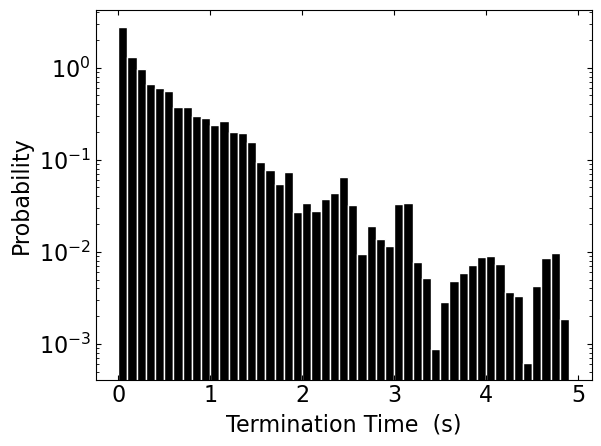

In [54]:
fontsize=16
fig,ax=plt.subplots()
bins=16
# bins=np.arange(0,0.4,0.02)
# bins=32
bins=np.arange(0,5,0.1)
ax.hist(np.array(t_lst)/1e3,color='k',bins=bins,density=True,alpha=1,label='Data',edgecolor='w')#,**kwargs)
format_plot(xlabel='Termination Time  (s)',ylabel='Probability',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_yscale('log')
# plt.tick_params(top=False, right=False,direction='in',which='both')
# plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

In [55]:
#TODO: overlay with termination times from the LPM
# fldr='/Users/timothytyree/Documents/GitHub/bgmc/python/data/creation_data'
fldr='/home/timothytyree/Documents/GitHub/bgmc/python/data/creation_data'
os.listdir(fldr)

['term_times_FK_chi_2.94_delta_0.13_Rcbar_0.85_r0_0.131.csv',
 'term_times_FK_chi_2.94_delta_0.1_Rcbar_0.85_r0_0.131.csv',
 'term_times_LR_chi_2.08_delta_0.13_Rcbar_1.21_r0_0.204.csv',
 'term_times_FK_no_creation.csv',
 'term_times_LR_no_creation.csv',
 'term_times_LR_chi_2.0_delta_0.1_Rcbar_1.25.csv',
 'term_times_LR_chi_2.08_delta_0.1_Rcbar_1.25_r0_0.204.csv',
 'term_times_LR_chi_2.0_delta_10.0_Rcbar_0.83_r0_0.204.csv']

In [56]:
t_values = np.array(t_lst)/1e3
mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(t_values)
print(f"{mtt=:.3f}±{Delta_mtt:.3f} s ({num_obs=}, {p_normal=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)

fn = 'term_times_LR_chi_2.08_delta_0.1_Rcbar_1.25_r0_0.204.csv'
# fn = 'term_times_LR_chi_2.0_delta_0.1_Rcbar_1.25.csv'
# fn = 'term_times_FK_chi_2.94_delta_0.1_Rcbar_0.85_r0_0.131.csv'
dirname=os.path.join(fldr,fn)
t_lst2=list(pd.read_csv(dirname,header=None).values.flatten())
mtt2,Delta_mtt2,num_obs2,p_normal2=comp_mean_bootstrap_uncertainty(np.array(t_lst2))
print(f"{mtt2=:.2f}±{Delta_mtt2:.2f} s ({num_obs2=}, {p_normal2=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)
# t_lst2

mtt=0.552±0.004 s (num_obs=112062, p_normal=0.4377)
mtt2=0.57±0.04 s (num_obs2=5000, p_normal2=0.0000)


In [57]:
hist,bins_edges = np.histogram(t_values,bins=bins,density=True)
hist2,bins_edges = np.histogram(t_lst2,bins=bins,density=True)
hist_lr = hist
hist_w_creation_lr = hist2
mtt_lr = mtt
mtt_w_creation_lr = mtt2

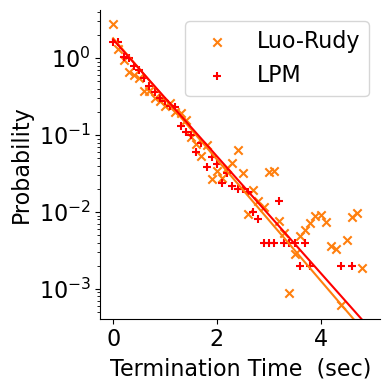

In [58]:
fig,ax=plt.subplots(figsize=(4,4))
ax.scatter(bins_edges[:-1],hist,label='Luo-Rudy',color='C1',marker='x')
ax.scatter(bins_edges[:-1],hist2,label='LPM',color='r',marker='+')
ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
format_plot(ax=ax,fontsize=fontsize,xlabel='Termination Time  (sec)',ylabel='Probability')
ax.legend(fontsize=fontsize,loc='upper right',frameon=True)
plt.tight_layout()
# ylim=ax.get_ylim()
ylim=(0.00041045639764998755, 4.221483966396934)
ax.set_ylim(ylim)

#plot exponential distrib for either mtt,mtt2
ax.plot(bins_edges,np.exp(-bins_edges/mtt)/mtt,color='C1')
ax.plot(bins_edges,np.exp(-bins_edges/mtt2)/mtt2,color='r')

plt.show()


# repeat for FK model

mtt=24266.95±208.06 ms (num_obs=81503, p_normal=0.8236)


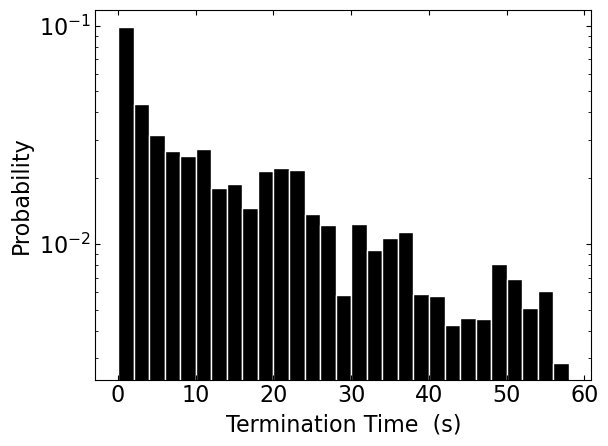

mtt=24.267±0.201 s (num_obs=81503, p_normal=0.9339)
mtt2=24.13±1.89 ms (num_obs2=400, p_normal2=0.1170)


In [59]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
# folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

N0=2
t_lst=[]
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        n_series = g.groupby(by='t')['n'].min()
        t0_values = n_series[n_series==N0].index.values
        tf = n_series.index.values.max()
        t_values = tf-t0_values
        #record
        t_lst.extend(t_values)
    except IndexError as e:
        pass
        #print(f"IndexError for {fn}: {e}")
n_series.max()

# mtt = np.mean(t_lst)
# bootstrap_95CI_Delta_mean?
# plt.hist(t_lst,bins=np.arange(0,10000,100),color='k')
# plt.show()

mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
print(f"{mtt=:.2f}±{Delta_mtt:.2f} ms ({num_obs=}, {p_normal=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)

fontsize=16
fig,ax=plt.subplots()
bins=16
# bins=np.arange(0,0.4,0.02)
# bins=32
# bins=np.arange(0,5,0.1)
# bins=np.arange(0,60,5)
bins=np.arange(0,60,2)
ax.hist(np.array(t_lst)/1e3,color='k',bins=bins,density=True,alpha=1,label='Data',edgecolor='w')#,**kwargs)
format_plot(xlabel='Termination Time  (s)',ylabel='Probability',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_yscale('log')
# plt.tick_params(top=False, right=False,direction='in',which='both')
# plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

#TODO: overlay with termination times from the LPM
fldr='/home/timothytyree/Documents/GitHub/bgmc/python/data/creation_data'
os.listdir(fldr)

t_values = np.array(t_lst)/1e3
mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(t_values)
print(f"{mtt=:.3f}±{Delta_mtt:.3f} s ({num_obs=}, {p_normal=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)

# fn = 'term_times_LR_chi_2.0_delta_0.1_Rcbar_1.25.csv'
fn = 'term_times_FK_chi_2.94_delta_0.1_Rcbar_0.85_r0_0.131.csv'
dirname=os.path.join(fldr,fn)
t_lst2=list(pd.read_csv(dirname,header=None).values.flatten())
mtt2,Delta_mtt2,num_obs2,p_normal2=comp_mean_bootstrap_uncertainty(np.array(t_lst2))
print(f"{mtt2=:.2f}±{Delta_mtt2:.2f} ms ({num_obs2=}, {p_normal2=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)
# t_lst2

hist,bins_edges = np.histogram(t_values,bins=bins,density=True)
hist2,bins_edges = np.histogram(t_lst2,bins=bins,density=True)

hist_fk = hist
hist_w_creation_fk = hist2
mtt_fk = mtt
mtt_w_creation_fk = mtt2

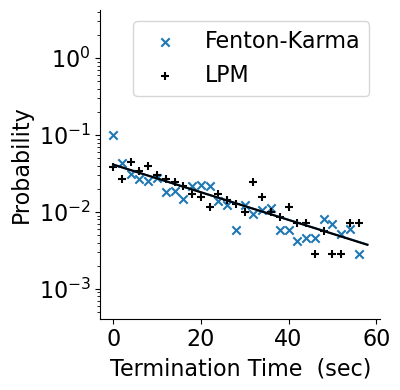

In [60]:
fig,ax=plt.subplots(figsize=(4,4))
ax.scatter(bins_edges[:-1],hist,label='Fenton-Karma',color='C0',marker='x')
ax.scatter(bins_edges[:-1],hist2,label='LPM',color='k',marker='+')
ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
format_plot(ax=ax,fontsize=fontsize,xlabel='Termination Time  (sec)',ylabel='Probability')
ax.legend(fontsize=fontsize,loc='upper right',frameon=True)
plt.tight_layout()
# plt.ylim(ylim)
ylim=(0.00041045639764998755, 4.221483966396934)
ax.set_ylim(ylim)

#plot exponential distrib for either mtt,mtt2
ax.plot(bins_edges,np.exp(-bins_edges/mtt)/mtt,color='C0',linestyle='-',alpha=1)
ax.plot(bins_edges,np.exp(-bins_edges/mtt2)/mtt2,color='k',alpha=1,linestyle='-')


plt.show()

# overlay LPM without creation

In [94]:
t_lstdir='/home/timothytyree/Documents/GitHub/bgmc/python/data/creation_data/term_times_LR_no_creation.csv'
t_lstdir2='/home/timothytyree/Documents/GitHub/bgmc/python/data/creation_data/term_times_FK_no_creation.csv'


In [95]:
t_lst=list(pd.read_csv(t_lstdir,header=None).values.flatten())
mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
print(f"{mtt=:.4f}±{Delta_mtt:.4f} ms ({num_obs=}, {p_normal=:.4f})")

t_lst2=list(pd.read_csv(t_lstdir2,header=None).values.flatten())
mtt2,Delta_mtt2,num_obs2,p_normal2=comp_mean_bootstrap_uncertainty(np.array(t_lst2))
print(f"{mtt2=:.4f}±{Delta_mtt2:.4f} ms ({num_obs2=}, {p_normal2=:.4f})")


mtt=0.1431±0.0021 ms (num_obs=5000, p_normal=0.9748)
mtt2=0.8357±0.0525 ms (num_obs2=400, p_normal2=0.0155)


In [96]:
bins=np.arange(0,5,0.1)
hist,bins_edges = np.histogram(t_lst,bins=bins,density=True)
hist2,bins_edges = np.histogram(t_lst2,bins=bins,density=True)

In [97]:
# bins=np.arange(0,5,0.1)
binsb=np.arange(0,60,2)

In [98]:
hist_wo_creation_lr = hist
hist_wo_creation_fk = hist2
# hist_wo_creation_fk = np.histogram(t_lst2,bins=binsb,density=True)[0]
mtt_wo_creation_lr = mtt
mtt_wo_creation_fk = mtt2

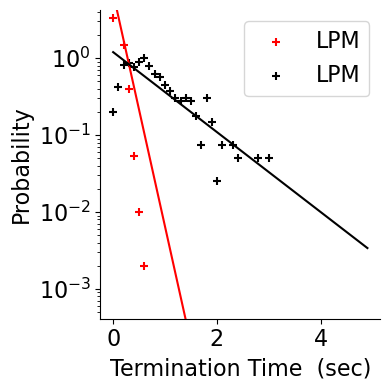

In [99]:
fig,ax=plt.subplots(figsize=(4,4))
ax.scatter(bins_edges[:-1],hist,label='LPM',color='r',marker='+')
ax.scatter(bins_edges[:-1],hist2,label='LPM',color='k',marker='+')
ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
format_plot(ax=ax,fontsize=fontsize,xlabel='Termination Time  (sec)',ylabel='Probability')
ax.legend(fontsize=fontsize,loc='upper right',frameon=True)
plt.tight_layout()
# plt.ylim(ylim)
ylim=(0.00041045639764998755, 4.221483966396934)
ax.set_ylim(ylim)

#plot exponential distrib for either mtt,mtt2
ax.plot(bins_edges,np.exp(-bins_edges/mtt)/mtt,color='r',linestyle='-',alpha=1)
ax.plot(bins_edges,np.exp(-bins_edges/mtt2)/mtt2,color='k',alpha=1,linestyle='-')

plt.show()

# combine the without creation plots with the creation plots for either full cardiac model

In [117]:
# (B) probability density.
# Bin width is 2 seconds.
# mtt=24.267±0.190 s (num_obs=81503, p_normal=0.3491)
# mtt2=24.13±1.91 ms (num_obs2=400, p_normal2=0.0184)
# mtt_wo_creation=0.8357±0.0538 ms (num_obs2=400, p_normal2=0.9630) (Bin width is 0.1 seconds.)
(24.267-24.13)/24.267
(24.27-24.1)/24.27

0.007004532344458103

In [100]:
bins=np.arange(0,5,0.1)
bins_edges_small = bins
bins=np.arange(0,60,2)
bins_edges = bins

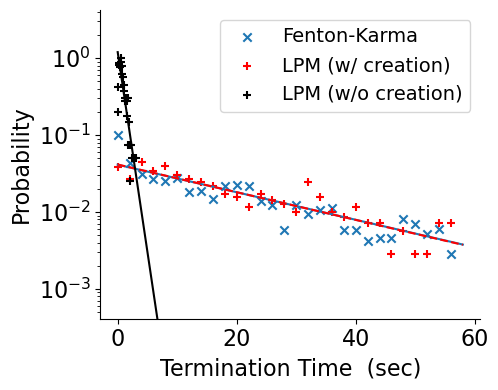

In [113]:
fig,ax=plt.subplots(figsize=(5,4))
ax.scatter(bins_edges[:-1],hist_fk,label='Fenton-Karma',color='C0',marker='x')
ax.scatter(bins_edges[:-1],hist_w_creation_fk,label='LPM (w/ creation)',color='r',marker='+')
ax.scatter(bins_edges_small[:-1],hist_wo_creation_fk,label='LPM (w/o creation)',color='k',marker='+')
ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
format_plot(ax=ax,fontsize=fontsize,xlabel='Termination Time  (sec)',ylabel='Probability')
ax.legend(fontsize=fontsize-2,loc='upper right',frameon=True)
plt.tight_layout()
# plt.ylim(ylim)
ylim=(0.00041045639764998755, 4.221483966396934)
ax.set_ylim(ylim)

#plot exponential distrib for either mtt,mtt2
ax.plot(bins_edges,np.exp(-bins_edges/mtt_fk)/mtt_fk,color='C0',linestyle='-',alpha=1)
ax.plot(bins_edges,np.exp(-bins_edges/mtt_w_creation_fk)/mtt_w_creation_fk,color='r',alpha=1,linestyle='--')
ax.plot(bins_edges,np.exp(-bins_edges/mtt_wo_creation_fk)/mtt_wo_creation_fk,color='k',alpha=1,linestyle='-')


plt.show()

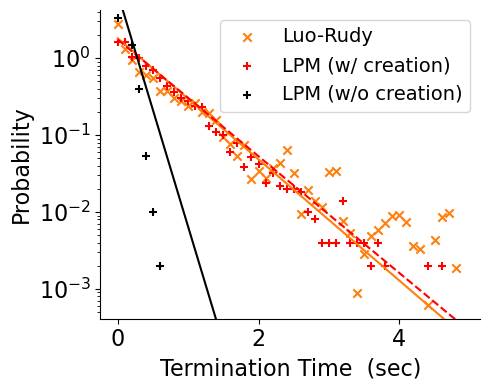

In [112]:
fig,ax=plt.subplots(figsize=(5,4))
ax.scatter(bins_edges_small[:-1],hist_lr,label='Luo-Rudy',color='C1',marker='x')
ax.scatter(bins_edges_small[:-1],hist_w_creation_lr,label='LPM (w/ creation)',color='r',marker='+')
ax.scatter(bins_edges_small[:-1],hist_wo_creation_lr,label='LPM (w/o creation)',color='k',marker='+')
ax.set_yscale('log')
ax.spines[['top','right']].set_visible(False)
format_plot(ax=ax,fontsize=fontsize,xlabel='Termination Time  (sec)',ylabel='Probability')
ax.legend(fontsize=fontsize-2,loc='upper right',frameon=True)
plt.tight_layout()
# plt.ylim(ylim)
ylim=(0.00041045639764998755, 4.221483966396934)
ax.set_ylim(ylim)

#plot exponential distrib for either mtt,mtt2
ax.plot(bins_edges_small,np.exp(-bins_edges_small/mtt_lr)/mtt_lr,color='C1',linestyle='-',alpha=1)
ax.plot(bins_edges_small,np.exp(-bins_edges_small/mtt_w_creation_lr)/mtt_w_creation_lr,color='r',alpha=1,linestyle='--')
ax.plot(bins_edges_small,np.exp(-bins_edges_small/mtt_wo_creation_lr)/mtt_wo_creation_lr,color='k',alpha=1,linestyle='-')


plt.show()

In [ ]:
#TODO: decide based on the manuscript's discussion which panel comes first.

# compute $\tau(N_0)$ versus $N_0$

In [19]:
dict_lst=[]
for N0 in range(2,16,2):
    t_lst=[]
    for fn in os.listdir(log_folder_parquet):
        try:
            trial_num = eval(fn.split('=')[1])
            # load tip position data
            g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
            n_series = g.groupby(by='t')['n'].min()
            t0_values = n_series[n_series==N0].index.values
            tf = n_series.index.values.max()
            t_values = tf-t0_values
            #record
            t_lst.extend(t_values)
        except IndexError as e:
            pass
            #print(f"IndexError for {fn}: {e}")
    mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
    dict_lst.append(dict(
        N0=N0,mtt=mtt,Delta_mtt=Delta_mtt,num_obs=num_obs,p_normal=p_normal
    ))
    print(f"{N0=}: {mtt=} ms")

N0=2: mtt=24266.950787087593 ms
N0=4: mtt=26863.92267982366 ms
N0=6: mtt=28152.536997269282 ms
N0=8: mtt=28317.872935118397 ms
N0=10: mtt=27544.009998960795 ms
N0=12: mtt=27934.011277948226 ms
N0=14: mtt=27661.864267361358 ms


In [20]:
df=pd.DataFrame(dict_lst)
df.head()

,N0,mtt,Delta_mtt,num_obs,p_normal
0,2,24266.950787,199.806738,81503,0.908882
1,4,26863.922680,114.864903,262674,0.448515
2,6,28152.536997,80.956573,490347,0.817226
3,8,28317.872935,75.275086,549971,0.430322
4,10,27544.009999,84.846802,442646,0.477141


In [21]:
n_series.max()

20

In [22]:
fn_out = os.path.join(folder,'mtt_vs_N0.csv')
df.to_csv(fn_out,index=False)
print(f"csv_dir = '{fn_out}'")

csv_dir = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/mtt_vs_N0.csv'


# visualize mean termination time conditioned on initial number of tips

In [23]:
csv_dir_fk = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/mtt_vs_N0.csv'
csv_dir_lr = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/mtt_vs_N0.csv'

In [24]:
dffk=pd.read_csv(csv_dir_fk)
dflr=pd.read_csv(csv_dir_lr)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/mtt_vs_N0.csv'

In [ ]:
yscale=1e-3
x_values1 = dffk['N0'].values
y_values1 = dffk['mtt'].values*yscale
yerr_values1 = dffk['Delta_mtt'].values*yscale
x_values2 = dflr['N0'].values
y_values2 = dflr['mtt'].values*yscale
yerr_values2 = dflr['Delta_mtt'].values*yscale

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x_values1,y_values1,color='C0',lw=2,label='Fenton-Karma')
ax.fill_between(x_values1,y_values1-yerr_values1,y_values1+yerr_values1,color='C0',lw=2,alpha=0.4)

ax.plot(x_values2,y_values2,color='C1',lw=2,label='Luo-Rudy')
ax.fill_between(x_values2,y_values2-yerr_values2,y_values2+yerr_values2,color='C1',lw=2,alpha=0.4)

format_plot(xlabel='Initial Number of Tips',ylabel='Mean Termination Time  (s)',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_yscale('log')
ax.legend(fontsize=12)
ax.set_xticks([2,4,6,8,10,12,14])
plt.show()

In [ ]:
3+1_1

In [ ]:
np.log(3)/3

In [ ]:
# Ninitial=14, R_c_bar=1.25, mean termination time: 0.653381050000028 +/- 0.018159030486425386 seconds (num_trials=5000)
# Ninitial=12, R_c_bar=1.25, mean termination time: 0.7304856760095639 +/- 0.05931961201580523 seconds (num_trials=5000)
# Ninitial=10, R_c_bar=1.25, mean termination time: 0.6745262240032438 +/- 0.035317313982767384 seconds (num_trials=5000)
# Ninitial=8, R_c_bar=1.25, mean termination time: 0.7279121360082963 +/- 0.05768301149384409 seconds (num_trials=5000)
# Ninitial=6, R_c_bar=1.25, mean termination time: 0.6834717560049279 +/- 0.04115161508164275 seconds (num_trials=5000)
# Ninitial=4, R_c_bar=1.25, mean termination time: 0.6713320280064632 +/- 0.050606042880702404 seconds (num_trials=5000)
# Ninitial=2, R_c_bar=1.25, mean termination time: 0.5571799440032732 +/- 0.036710952082747786 seconds (num_trials=5000)
N_lst=[14,12,10,8,6,4,2,]
tau_lst=[0.653381050000028,0.7304856760095639,0.6745262240032438,0.7279121360082963,0.6834717560049279,0.6713320280064632,0.5571799440032732]
Delta_tau_lst=[0.018159030486425386,0.05931961201580523,0.035317313982767384,0.05768301149384409,0.04115161508164275,0.050606042880702404,0.036710952082747786]
# df_lpm=pd.DataFrame(N=N_lst,tau=tau_lst,Delta_tau=Delta_tau_lst)
# df_lpm

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))
# ax.plot(x_values1,y_values1,color='C0',lw=2,label='Fenton-Karma')
# ax.fill_between(x_values1,y_values1-yerr_values1,y_values1+yerr_values1,color='C0',lw=2,alpha=0.4)

ax.plot(x_values2,y_values2,color='C1',lw=2,label='full cardiac model')
ax.fill_between(x_values2,y_values2-yerr_values2,y_values2+yerr_values2,color='C1',lw=2,alpha=0.4)

ax.errorbar(x=N_lst,y=tau_lst,yerr=Delta_tau_lst,marker='x',color='k',label='particle with creation')

format_plot(xlabel='Initial Number of Tips',ylabel='Mean Termination Time  (s)',ax=ax,fontsize=fontsize)
# ax.set_yscale('log')
ax.legend(fontsize=12,loc='lower right')
ax.set_xticks([2,4,6,8,10,12,14])
ax.set_ylim([0,1])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(top=False, right=False,direction='in',which='both')
# ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()